In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Reviews_df=pd.read_excel('Reviews15.xlsx')

In [3]:
def nan_to_string(text):
    if type(text) != str:
        return ' '
    else:
        return text
Reviews_df['Clean Review Text'] = Reviews_df['Review Text'].apply(nan_to_string)
Reviews_df['Clean Review Tags'] = Reviews_df['Review Tags'].apply(nan_to_string)

In [4]:
Reviews_df['Clean Review Tags'] = Reviews_df['Clean Review Tags'].apply(lambda x: (" ".join(x.split())).lower() )
Reviews_df['Clean Review Text'] = Reviews_df['Clean Review Text'].apply(lambda x: (" ".join(x.split())).lower() )

In [5]:
def text_plus_tags(row):
    return row['Clean Review Text'] + " " + row['Clean Review Tags']
Reviews_df['Full Review'] = Reviews_df.apply(text_plus_tags, axis=1)

In [21]:
#Using NLTK to find only the stem of the word.
import nltk
# Remove proper nouns
#Reviews_df['Full Review Public'] = Reviews_df['Full Review'].apply(lambda text: " ".join([word for word, tag in nltk.tag.pos_tag(text.split()) if tag != 'NNP' and tag != 'NNPS']) )
#Remove puncutation
import string
pun_list = str.maketrans(string.punctuation, 32*" ")#replaces punctuation with a space, to simply remove: str.maketrans('', '', string.punctuation)
Reviews_df['Full Review NoPun'] = Reviews_df['Full Review'].apply(lambda text: text.translate( pun_list))
#stem the words
#stemmer = nltk.stem.PorterStemmer()
#Reviews_df['Full Review Stem'] = Reviews_df['Full Review NoPun'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split(" ")]))

In [8]:
from  nltk.classify.textcat import TextCat
tc=TextCat()
def which_language(text):
    return tc.guess_language(text)
languages=Reviews_df[Reviews_df['Gender']=='N/A']['Clean Review Text'].apply(which_language)
#which_language(Reviews_df.loc[120003]['Clean Review Text'])

In [38]:
from sklearn.feature_extraction.text import CountVectorizer#, stop_words='english'
new_stop_words = {'he','she','him','his','her','has', 'had','ll','are', 'the','a','as','for','and','has','had','have','here', 'is','it','in','if','of','on','or','so','to','then','that','these','those','was'}
vectorizer = CountVectorizer(ngram_range=(1, 5),stop_words = new_stop_words, min_df=.01, max_df=.98)#, max_features=25000)#words and pairs of words
X = vectorizer.fit_transform(Reviews_df['Full Review NoPun'])#'Clean Review Text'
X_vec=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()#smooth_idf=False)
tfidf = transformer.fit_transform(X.toarray())
X_vec_transform=pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

In [41]:
from sklearn.model_selection import train_test_split

X_all=X_vec_transform
y_all = Reviews_df['Overall Rating']#['Review Qverall Quality']#

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)

In [42]:
from sklearn.metrics import  mean_squared_log_error,  mean_squared_error

In [43]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.00001, max_iter=1000)
lasso.fit(X_train, y_train)
predictions= lasso.predict(X_test)
print(mean_squared_error(y_train, lasso.predict(X_train) ))
print(mean_squared_error(y_test,predictions) )

0.403767937634
0.408611317512


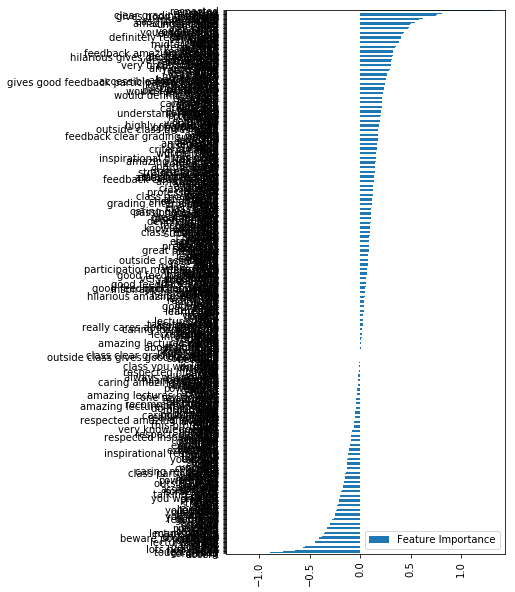

,Feature Importance
accent,-1.201800
confusing,-0.891742
tough grader,-0.761437
bad,-0.647221
test heavy,-0.607533
office,-0.591452
lots homework,-0.577494
not,-0.566045
teach,-0.545983
get ready,-0.541573


In [70]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X_all.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(5,10))
plt.xticks(rotation=90)
plt.show()
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance")

In [55]:
def is_relevant(word):
    try:
        count=X_vec.sum(axis=0)[vectorizer.vocabulary_[word]]
        print(word, "appears", count, "times.")
    except:
        print(word, "appears in less than 1% of reviews.")
#is_relevant('slides')

def vectorize_and_transform(df_column_original):
    import nltk
    from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
    df_column = df_column_original.apply(lambda text: " ".join([word for word, tag in nltk.tag.pos_tag(text.split()) if tag != 'NN' and tag != 'NNP' and tag != 'NNS' and tag != 'PRP']) )
    local_stop_words = {'he','she','him','his','her','has', 'had','ll','are', 'the','a','as','for','and','has','had','have','here', 'is','it','in','if','of','on','or','so','to','then','that','these','those','was'}
    local_vectorizer = CountVectorizer(ngram_range=(1, 5),stop_words = local_stop_words, min_df=.01, max_df=.98)#, max_features=25000)#words and pairs of words
    X_local = local_vectorizer.fit_transform(df_column)
    X_local_vec=pd.DataFrame(X_local.toarray(),columns=local_vectorizer.get_feature_names(), index=df_column.index)
    local_transformer = TfidfTransformer()#smooth_idf=False)
    local_tfidf = transformer.fit_transform(X_local_vec)
    X_vec_transform_local=pd.DataFrame(local_tfidf.toarray(),columns=local_vectorizer.get_feature_names(), index=df_column.index)
    wc = WordCloud().generate(" ".join(df_column))
    plt.show()
    return X_vec_transform_local

def further_context(word):
    from sklearn.linear_model import Lasso
    try:
        is_relevant(word)
        reviews_subset=vectorize_and_transform(Reviews_df[X_vec[word]>0]['Clean Review Text'])
        scores_subset=Reviews_df[X_vec[word]>0]['Overall Rating']
        subset_lasso = Lasso(alpha=.00001, max_iter=10000)
        subset_lasso.fit(reviews_subset, scores_subset)
        #predictions= lasso.predict(X_test)
        print(mean_squared_error(scores_subset, subset_lasso.predict(reviews_subset) ))
        #print(mean_squared_error(y_test,predictions) )
        FI_subset_lasso = pd.DataFrame({"Feature Importance":subset_lasso.coef_}, index=reviews_subset.columns)
        sorted_FI=FI_subset_lasso.sort_values("Feature Importance",ascending=False)
        print(sorted_FI[0:3][:])
        print(sorted_FI[-3:][:])
    except:
        print("No further context is possible.")
#further_context('slides')

In [56]:
further_context('slides')#stemmer.stem('slides'))

slides appears 4087 times.
0.439272667358
                Feature Importance
amazing                   1.310097
always willing            1.308620
go class                  1.250048
                Feature Importance
reads                    -1.059997
just reads off           -1.115664
worst                    -1.618627


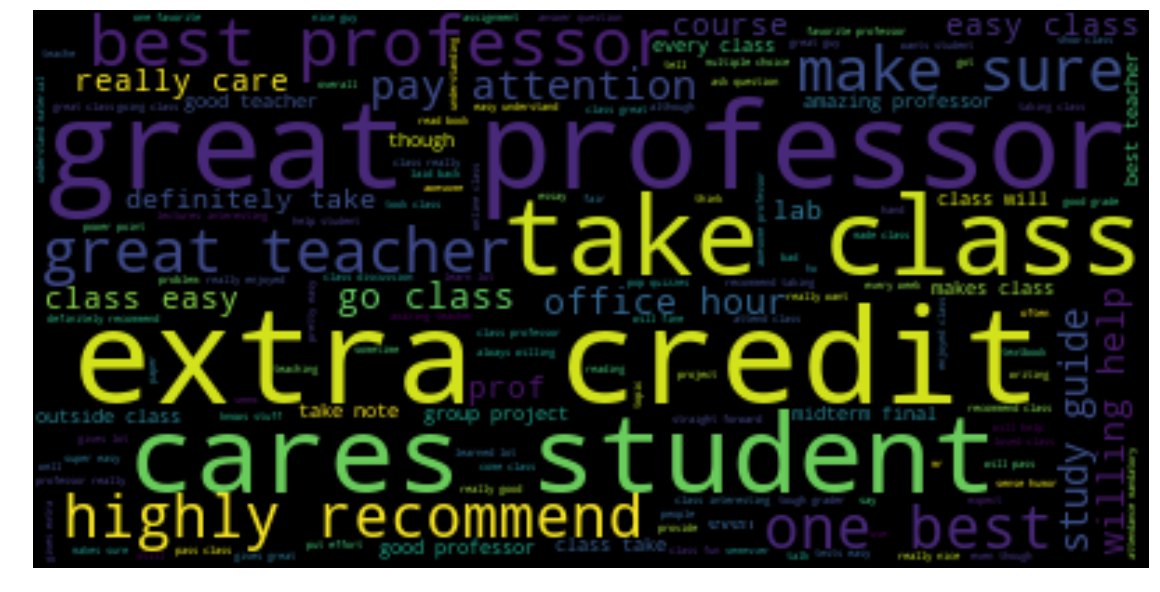

In [67]:
from wordcloud import WordCloud

wc = WordCloud().generate(" ".join(Reviews_df['Clean Review Text']))
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.show()